**Week 4 Assignment - Text Classification using Matrix Factorization**

In this notebook, I will develop an unsupervised learning model utilizing matrix factorization to categorize news articles as one of five labels: sports, business, politics, entertainment, and tech. I will then compare the results with a separate supervised learning model based on the Random Forest method. The data comes from the Kaggle Competition, "BBC News Classification". 

In [1]:
#Load Python libraries
import pandas as pd
import numpy as np

In [2]:
#Import the data
train_data = pd.read_csv("BBC News Train.csv")
test_data = pd.read_csv("BBC News Test.csv")

**Exploratory Data Analysis and Data Cleaning**

First, let's inspect the training and test data. The training data consists of 1490 samples of news articles with three columns: Article ID, Text, and Category. The text is in the format of one large string per row of the dataframe. The test data has 735 rows of the same format, but missing the Category column.

In [3]:
train_data

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [4]:
test_data

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


A histogram of the Category column of the training data shows a fairly equal sample size of articles from each category.

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

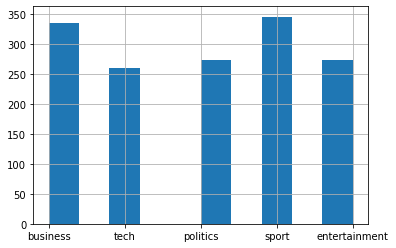

In [5]:
train_data['Category'].hist()
train_data['Category'].value_counts()

Here is a histogram of the number of words in each article. We see that most articles have fewer than 500 words and almost all have fewer than 1000.

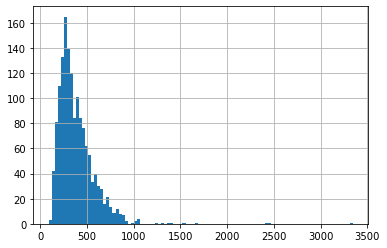

In [6]:
def word_count(text):
    words = text.split()
    return len(words)

train_data['Word_Count'] = train_data['Text'].apply(word_count)
train_data['Word_Count'].hist(bins=100)

Below are the mean word counts for each category. Business, sports, and entertaiment are very close, while articles in politics and tech are significantly longer on average.

In [77]:
def mean_word_count(Category):
    print(Category, 
          train_data[train_data['Category'] == Category]['Word_Count'].mean())
    
mean_word_count('business')
mean_word_count('sport')
mean_word_count('politics')
mean_word_count('entertainment')
mean_word_count('tech')

business 334.16964285714283
sport 335.3468208092485
politics 449.68978102189783
entertainment 333.9120879120879
tech 501.8582375478927


Let's have a look at some words from one example article:

In [122]:
train_data.iloc[1][1].split()[:50]

['german',
 'business',
 'confidence',
 'slides',
 'german',
 'business',
 'confidence',
 'fell',
 'in',
 'february',
 'knocking',
 'hopes',
 'of',
 'a',
 'speedy',
 'recovery',
 'in',
 'europe',
 's',
 'largest',
 'economy.',
 'munich-based',
 'research',
 'institute',
 'ifo',
 'said',
 'that',
 'its',
 'confidence',
 'index',
 'fell',
 'to',
 '95.5',
 'in',
 'february',
 'from',
 '97.5',
 'in',
 'january',
 'its',
 'first',
 'decline',
 'in',
 'three',
 'months.',
 'the',
 'study',
 'found',
 'that',
 'the']

In order to build a model that categorizes articles based on the word content, it will be helpful to remove common words such as "the", "that", and "is", which can't reasonably be expected to help identify the category of the article. One efficient way of doing this is to remove words included in the nltk library's list of "stop words", shown here:

In [124]:
#!pip install nltk
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words[:50]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be']

There are a few more steps needed to clean the text. One is to remove punctuation marks, so that strings like "said" and "said." are not treated as two different words. Another is to remove single-character words such as "s", which appear to be left over from split contractions. Finally, I have decided to treat currency symbols and percent signs attached to words as separate words, as they represent whole words that are spoken when read aloud. The function below implements these cleaning steps, along with removing stop words.

In [9]:
def Clean_text(text):
    words = []
    for word in text.split():
        
        #Remove punctuation marks at the ends of words
        if word[-1] in ['.', ',', ':', '?', '!']:
            word = word[:-1]
            
        #Remove single-character words and stop words
        if len(word) < 2:
            continue
        if word in stop_words:
            continue
            
        #Add currency symbols and percent signs as separate words
        if word[0] == '$' or word[0] == '£' or word[0] == '€':
            words.append(word[0])
            word = word[1:]            
        if word[-1] == '%':
            words.append(word[-1])
            word = word[:-1]
        
        words.append(word)
        
    return ' '.join(words)

train_data['Clean_text'] = train_data['Text'].apply(Clean_text)
test_data['Clean_text'] = test_data['Text'].apply(Clean_text)

The next step in EDA is to look at some of the most frequent words in each article category. I use the following function to display the top 20 most frequent words overall and by category.

In [10]:
def TopWords(category, num):
    
    if category == None:
        df = pd.DataFrame(train_data['Clean_text'].sum().split(),columns=['Words'])
    else:
        df = pd.DataFrame(train_data[train_data['Category'] == category]['Clean_text'].sum().split(),columns=['Words'])
    
    return(df['Words'].value_counts()[:num])

In [11]:
TopWords(None, 20)

said          4783
mr            1972
would         1710
also          1424
new           1320
people        1319
%             1270
year          1187
us            1176
one           1154
could         1030
first          891
last           882
two            812
world          787
time           746
government     745
uk             719
$              709
years          637
Name: Words, dtype: int64

In [12]:
TopWords('business',20)

said          1089
%              826
us             491
$              463
year           405
mr             393
would          308
also           278
market         275
new            273
firm           261
growth         255
company        251
last           235
economy        227
government     214
£              209
economic       202
bank           201
sales          198
Name: Words, dtype: int64

In [13]:
TopWords('tech',20)

said          1049
people         646
mr             349
also           348
new            347
one            325
would          322
mobile         317
could          308
technology     299
users          267
software       264
%              263
use            257
music          253
net            244
many           236
digital        235
year           225
phone          225
Name: Words, dtype: int64

In [14]:
TopWords('politics',20)

said          1428
mr            1072
would          709
labour         477
government     461
election       390
people         370
blair          366
party          359
also           308
minister       282
new            275
could          271
£              263
brown          251
uk             233
told           219
plans          211
public         204
prime          193
Name: Words, dtype: int64

In [15]:
TopWords('sport',20)

said       630
game       348
first      323
england    321
win        292
world      260
last       255
two        252
one        238
would      233
back       220
time       218
also       213
players    204
cup        203
new        195
play       189
ireland    186
side       186
wales      177
Name: Words, dtype: int64

In [16]:
TopWords('entertainment',20)

said        587
film        550
best        404
also        277
one         255
year        253
music       252
us          248
new         230
show        218
first       184
awards      183
number      165
actor       164
uk          163
band        161
last        158
$           156
director    155
mr          150
Name: Words, dtype: int64

We see that some words such as "said" and "also" are common in all categories and therefore probably won't be very helpful as predictors. On the other hand, each category has words in the top 20 that don't make the top 20 in any other category. These include "market" and "growth" for business, "technology" and "software" for tech, "election" and "party" for politics, "game" and "players" for sport, and "film" and "music" for entertainment.

Of course, looking at these top 20 words doesn't tell the whole story, as there could be less common words that are more unique to certain categories. To build a model, we need a way of quantifying each word's relevance to each document.

**TF-IDF Vectorization**

TF-IDF is a method of transforming text into a vector of numerical features suitable for training machine learning models. It stands for Term Frequency-Inverse Document Frequency. There are two intuitive quantities involved:

Term Frequency - how often a word occurs in a single document

Document Frequency - how often a word occurs accross all documents

Multiplying term frequency by the inverse of document frequency gives a quantity which represents the frequency of a word in a document as compared to its overall frequency. A word that occurs often within a document might not be particularly relevant if it occurs similarly often throughout the collection of documents. Such a word would have a TF-IDF value close to 1. A word with a high TF and low DF will have a larger TF-IDF value, implying that its frequent presence in the document is significant. A word with a low TF and high DF will have a smaller TF-IDF value, meaning that its absence is significant.

**Model Building and Training**

I will start by using sklearn's TF-IDF Vectorizer with default parameters, meaning that all words are included. The result is a feature map of size 24,680 for each entry in the training dataset.

In [17]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(train_data['Clean_text'])
test_tfidf = tfidf_vectorizer.transform(test_data['Clean_text'])
train_tfidf.shape

(1490, 24680)

I will use the Non-negative Matrix Factorization (NMF) method to attempt to decompose this large feature matrix into five components. NMF produces two matrices: the W matrix - samples vs. components, and the H matrix - components vs. features. Here is a sample of the W matrix after decomposing the training data:

In [18]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=5)
fitted_nmf = nmf.fit(train_tfidf)
W_train = fitted_nmf.transform(train_tfidf)
W_test = fitted_nmf.transform(test_tfidf)
W_train[:10]

array([[0.00096477, 0.03808838, 0.00618299, 0.00403145, 0.05321764],
       [0.        , 0.        , 0.        , 0.        , 0.19960027],
       [0.01257623, 0.02105402, 0.02801683, 0.00064516, 0.11716327],
       [0.        , 0.        , 0.22932779, 0.        , 0.        ],
       [0.00734344, 0.00589711, 0.0074438 , 0.00803036, 0.0706685 ],
       [0.03232519, 0.06478505, 0.00586053, 0.00923155, 0.        ],
       [0.14615602, 0.        , 0.        , 0.        , 0.        ],
       [0.00998755, 0.02859694, 0.        , 0.14585602, 0.        ],
       [0.        , 0.        , 0.        , 0.00259796, 0.12921178],
       [0.        , 0.        , 0.        , 0.13670478, 0.03710177]])

The rows in the W matrix represent the strength of the five components for each article in the dataset. To transform these to categories, I will create an index vector by recording the column with the maximum value in each row.

In [19]:
idx_vec = [np.argmax(row) for row in W_train]
idx_vec[:10]

[4, 4, 4, 2, 4, 1, 0, 3, 4, 3]

Now we have predicted labels for the training data, but we don't which labels correspond to which article category. The code below tests every possible mapping of indicies to categories and returns the one with the highest accuracy.

In [57]:
from itertools import permutations

Categories = ['sport', 'business', 'politics', 'entertainment', 'tech']

def get_accuracy(label_true, label_pred):
    n = len(label_true)
    acc = 0

    for i in range(n):
        if label_true[i] == label_pred[i]:
            acc = acc + 1
    
    return acc/n
                
def idx_to_label(idx_vec, label_vec):
    n = len(idx_vec)
    
    perms = list(permutations(Categories))
    best_acc = 0
    
    for p in perms:
        label_dict =  {0:p[0], 
                       1:p[1], 
                       2:p[2], 
                       3:p[3], 
                       4:p[4] }
        
        yp = [label_dict[i] for i in idx_vec]
        acc = get_accuracy(label_vec, yp)
        
        if acc > best_acc:
            best_acc = acc
            best_dict = label_dict
    
    return best_dict
           

With the best index-to-label dictionary, we have a training accuracy of 91.3%

In [58]:
y_train = train_data['Category']
label_dict = idx_to_label(idx_vec, y_train)
yp_train = [label_dict[i] for i in idx_vec]
print(label_dict)
print(get_accuracy(y_train, yp_train))


{0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}
0.9134228187919463


Let's have a look at the confusion matrix to see how the different categories performed.

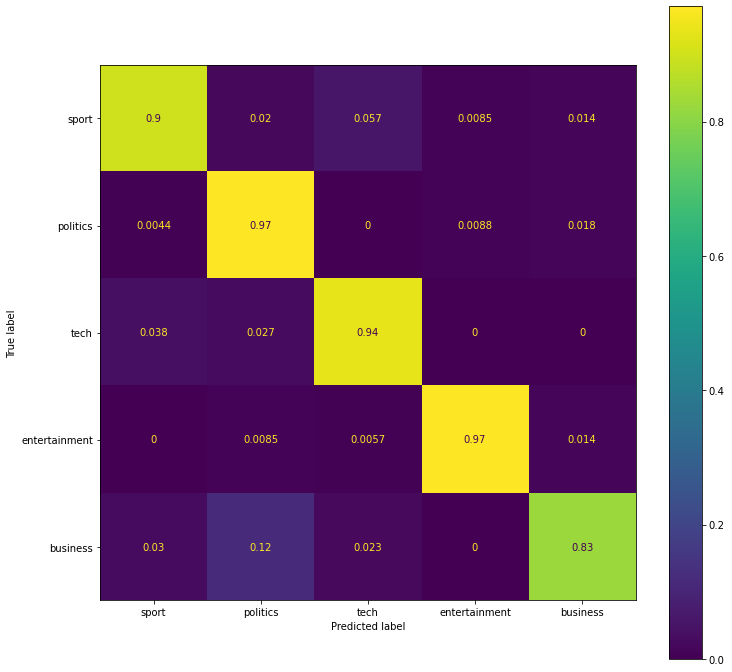

In [90]:
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(yp_train, y_train, normalize='true')
disp = sklearn.metrics.ConfusionMatrixDisplay(cfm,display_labels=['sport','politics','tech','entertainment','business'])
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.show()

The confusion matrix shows that the performance accross the categories is uneven, with politics and entertainment identified correctly 97% of the time compared to only 83% for business. Business is most often mistaken for politics, suggesting that the algorithm favors politics too much. Perhaps this reflects a limitation of the unsupervised learning approach, as the algorithm is not explicited trained on the provided labels, but rather tries to extract undefined features.

**Model Optimization**

To optimize the model, I will tune the hyperparameters of the TD-IDF Vectorizer, specifically the parameters "min_df" and "max_df", which set minimum and maximum values of Document Frequency for words to be included in the feature space. I will test minimum values from 0.0 to 0.05 and maximum values from 0.5 to 1.0. To find the best combination, I will use 5-fold cross validation, training on 80% of the data and testing on 20%, and averaging the testing accuracy accross all five folds.

In [119]:
def nmf_predict(train, test, min_df, max_df):
    
    tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df)
    nmf = NMF(n_components=5)
    
    train_tfidf = tfidf_vectorizer.fit_transform(train['Clean_text'])
    test_tfidf = tfidf_vectorizer.transform(test['Clean_text'])

    nmf.fit(train_tfidf)
    W_train = nmf.transform(train_tfidf)
    W_test = nmf.transform(test_tfidf)
    y_train = train['Category']

    idx_vec_train = [np.argmax(row) for row in W_train]
    idx_vec_test = [np.argmax(row) for row in W_test]
    label_dict = idx_to_label(idx_vec_train, y_train)
    
    yp_test = [label_dict[i] for i in idx_vec_test]
    return yp_test

def param_search(max_df, min_df):
    
    shuffled_data = train_data.sample(frac=1.0, random_state=42).reset_index(drop=True)
    n_folds = 5
    fold_length = shuffled_data.shape[0]//n_folds
    folds = []
    for i in range(n_folds):
        folds.append(shuffled_data[i*fold_length:(i+1)*fold_length].reset_index(drop=True))
        
    N = len(max_df)
    M = len(min_df)
    param_grid = np.zeros((N,M))

    for n in range(N):
        for m in range(M):

            acc = []
            for i in range(n_folds):
                test = folds[i].reset_index(drop=True)
                train = pd.concat([folds[j] for j in range(n_folds) if j != i]).reset_index(drop=True)
                y_test = test['Category']
                yp_test = nmf_predict(train, test, min_d, max_d)
                acc.append( get_accuracy(y_test, yp_test) )

            accuracy = np.mean(acc)
            #print(accuracy, max_df[i], min_df[j])
            param_grid[n][m] = accuracy

    return param_grid

In [120]:
max_df = [0.5, 0.55, 0.6, 0.65, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
min_df = [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]

param_grid = param_search(max_df, min_df)

The following heatmap shows accuracy values accross the parameter space. It seems that maximum DF values don't make much difference, while minimum values should be kept low. The best performing combination was a minimum of 0.005 and maximum of 0.55.

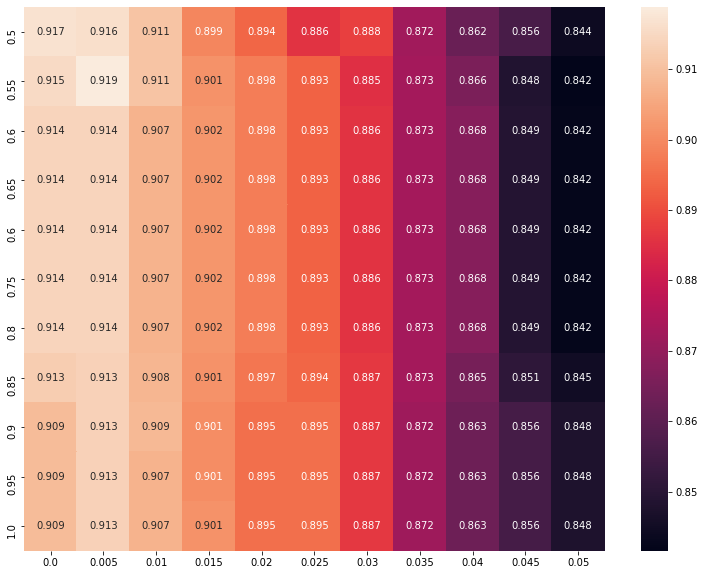

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(13,10))
sns.heatmap(param_grid,xticklabels=min_df,yticklabels=max_df,annot=True,fmt=".3f")

**Results**

Using these new optimized hyperparameters, I will now evaluate the accuracy of the model on the complete training dataset and on the testing set via Kaggle.

In [63]:
yp_train = nmf_predict(train_data, train_data, 0.005, 0.55)
yp_test = nmf_predict(train_data, test_data, 0.005, 0.55)

print("Training Accuracy = ", get_accuracy(train_data['Category'], yp_train))

#Create csv file to submit to Kaggle
submission_nmf = pd.DataFrame({'ArticleId':test_data['ArticleId'], 'Category':yp_test})
submission_nmf.to_csv('submission_nmf.csv', index=False)

Training Accuracy =  0.9187919463087248


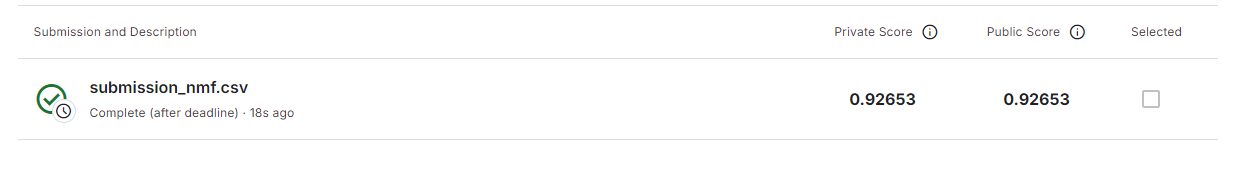

In [61]:
#Screenshot of Kaggle score
from IPython.display import Image
Image("Screenshot 2024-10-12 220810.png")

The results are a training accuracy of 91.9% (a very modest improvement from the default model) and a testing accuracy of 92.7%.

**Comparison to Supervised Learning**

I will now try a supervised learning model and see how it compares to the NMF model. My model of choice is Random Forest, given that this is a classification problem with a large number of features. Using the tuned TF-IDF matrix as input, I will first perform hyperparameter tuning by varying the number of trees and maximum features per tree and selecting the best combination using 5-fold cross validation.

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

tfidf_vectorizer = TfidfVectorizer(max_df=0.55, min_df=0.005)
train_tfidf = tfidf_vectorizer.fit_transform(train_data['Clean_text'])
test_tfidf = tfidf_vectorizer.transform(test_data['Clean_text'])

RF = RandomForestClassifier()
X_train = train_tfidf
y_train = train_data['Category']

param_grid = {
    'n_estimators': [100,500,1000],
    'max_features': [100,500,1000,5000],
}

grid_search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

{'max_features': 100, 'n_estimators': 500}
0.9557046979865772
Training Accuracy =  1.0


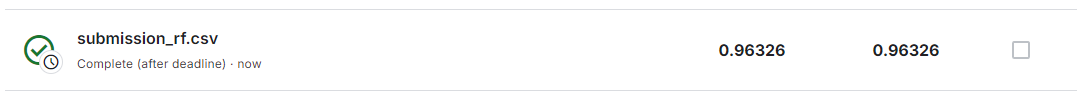

In [94]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print("Training Accuracy = ", get_accuracy(train_data['Category'],
                                           grid_search.predict(X_train)))
yp_test = grid_search.predict(test_tfidf)
submission_rf = pd.DataFrame({'ArticleId':test_data['ArticleId'], 'Category':yp_test})
submission_rf.to_csv('submission_rf.csv', index=False)
Image("Screenshot 2024-10-13 022643.png")

My Random Forest model achieves a training accuracy of 100% and a testing accuracy 96.3%, significantly higher than the NMF model. It is not surprising that the supervised learning model performed better when a large set of labeled data was available.

Next, let's see how the performance of both models depends on the size of the data. I will compare them using 10%, 25%, and 50% of samples.

In [99]:
df_10 = train_data.sample(frac=0.1, random_state=42).reset_index(drop=True)
df_25 = train_data.sample(frac=0.25, random_state=42).reset_index(drop=True)
df_50 = train_data.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [100]:
def rf_predict(train, test, max_features, n_estimators):
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.55, min_df=0.005)
    train_tfidf = tfidf_vectorizer.fit_transform(train['Clean_text'])
    test_tfidf = tfidf_vectorizer.transform(test['Clean_text'])
    
    RF = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators)
    RF.fit(train_tfidf, train['Category'])
    return RF.predict(test_tfidf)

In [101]:
#NMF Test Predictions
yp_10_nmf = nmf_predict(df_10, test_data, 0.005, 0.55)
yp_25_nmf = nmf_predict(df_25, test_data, 0.005, 0.55)
yp_50_nmf = nmf_predict(df_50, test_data, 0.005, 0.55)

#RF Test Predictions
yp_10_rf = rf_predict(df_10, test_data, 100, 500)
yp_25_rf = rf_predict(df_25, test_data, 100, 500)
yp_50_rf = rf_predict(df_50, test_data, 100, 500)

In [102]:
submission_nmf_10 = pd.DataFrame({'ArticleId':test_data['ArticleId'], 'Category':yp_10_nmf})
submission_nmf_10.to_csv('submission_nmf_10.csv', index=False)

submission_nmf_25 = pd.DataFrame({'ArticleId':test_data['ArticleId'], 'Category':yp_25_nmf})
submission_nmf_25.to_csv('submission_nmf_25.csv', index=False)

submission_nmf_50 = pd.DataFrame({'ArticleId':test_data['ArticleId'], 'Category':yp_50_nmf})
submission_nmf_50.to_csv('submission_nmf_50.csv', index=False)

submission_rf_10 = pd.DataFrame({'ArticleId':test_data['ArticleId'], 'Category':yp_10_rf})
submission_rf_10.to_csv('submission_rf_10.csv', index=False)

submission_rf_25 = pd.DataFrame({'ArticleId':test_data['ArticleId'], 'Category':yp_25_rf})
submission_rf_25.to_csv('submission_rf_25.csv', index=False)

submission_rf_50 = pd.DataFrame({'ArticleId':test_data['ArticleId'], 'Category':yp_50_rf})
submission_rf_50.to_csv('submission_rf_50.csv', index=False)

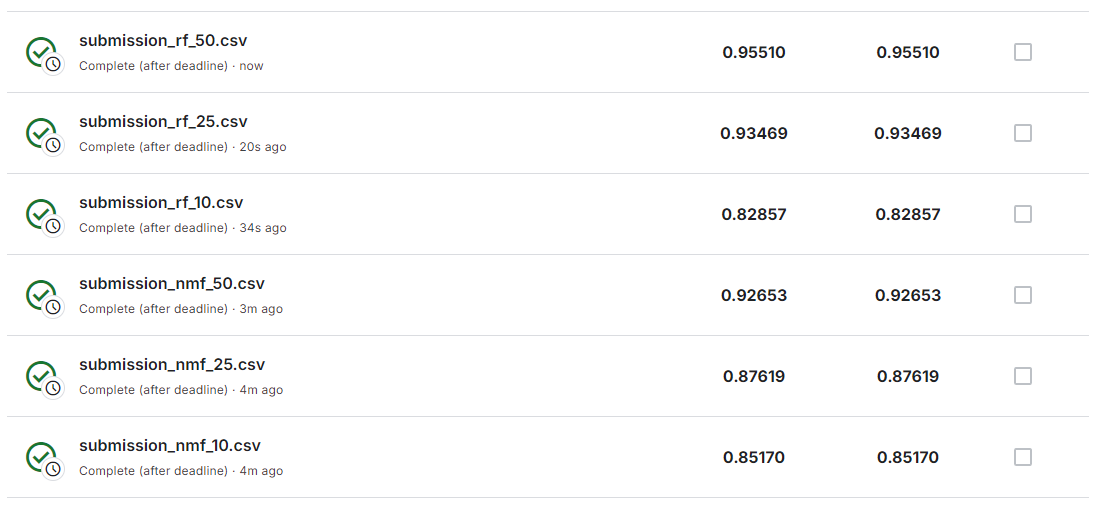

In [105]:
#Kaggle Submission Results
Image("Screenshot 2024-10-13 030235.png")

In [108]:
#Training Predictions
for df in [df_10, df_25, df_50]:
    
    yp_nmf_train = nmf_predict(df, df, 0.005, 0.55)
    yp_rf_train = rf_predict(df, df, 100, 500)
    
    print(get_accuracy(df['Category'],yp_nmf_train))
    print(get_accuracy(df['Category'],yp_rf_train))

0.912751677852349
1.0
0.9112903225806451
1.0
0.9288590604026845
1.0


Text(0, 0.5, 'Accuracy')

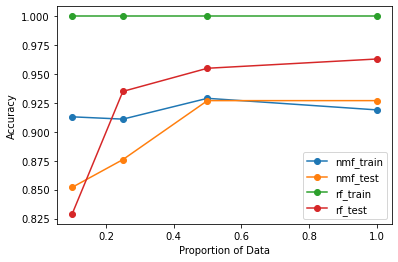

In [113]:
#Plot training and test results for both models
X = [0.1, 0.25, 0.5, 1.0]
nmf_train = [0.913, 0.911, 0.929, 0.919]
nmf_test = [0.852, 0.876, 0.927, 0.927]
rf_train = [1.0, 1.0, 1.0, 1.0]
rf_test = [0.829, 0.935, 0.955, 0.963]

plt.plot(X, nmf_train, label='nmf_train', marker='o')
plt.plot(X, nmf_test, label='nmf_test', marker='o')
plt.plot(X, rf_train, label='rf_train',marker='o')
plt.plot(X, rf_test, label='rf_test',marker='o')
plt.legend()
plt.xlabel("Proportion of Data")
plt.ylabel("Accuracy")

The plot above shows several interesting results. While the RF model scores 100% on training accuracy for all sample sizes, it's testing accuracy for the lowest sample size (10%) is below that of the NMF model. It seems that the NMF model performs better with small sample sizes, and is less prone to overfitting. In fact, with large sample sizes, the training and testing accuracy for the NMF model is almost exactly the same, while the RF testing accuracy is always a little below the training accuracy. Nevertheless, RF still looks like the clear winner in terms of accuracy with a sufficiently large sample.


**TD-IDF Reference**
https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/